In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os

import tensorflow as tf
import numpy as np

SEED = 1234
np.random.seed(SEED)
tf.random.set_seed(SEED)  

In [3]:
from os import listdir, makedirs
from os.path import isfile, join, basename, splitext
from random import seed, shuffle
cwd = os.getcwd()
cwd

'/content'

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Dec  9 18:29:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!unzip /content/drive/My\ Drive/Development_Dataset.zip

Archive:  /content/drive/My Drive/Development_Dataset.zip
  inflating: Development_Dataset/LICENSE.txt  
   creating: Development_Dataset/Test_Dev/
   creating: Development_Dataset/Test_Dev/Bipbip/
   creating: Development_Dataset/Test_Dev/Bipbip/Haricot/
   creating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00211.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00581.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00721.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00951.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_01341.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_02421.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_02781.jpg  
  inflating: Developm

In [ ]:
!ls /content/Development_Dataset/Training/Bipbip/Haricot

Images	Masks


In [7]:
from os import listdir, makedirs
from os.path import isfile, join, basename, splitext
from random import seed, shuffle

def split_dataset(training_dir, split_dir, training_percentage=0.90):
    """
    Starting from a training directory, creates a split directory
    with two text files, enumerating the images present in the 
    training and the validation set. 
    """

    seed(1234)

    file_names = [f for f in listdir(training_dir) if isfile(join(training_dir, f))]
    shuffle(file_names)

    split = int(len(file_names)*training_percentage)
    train_file_names = "\n".join([splitext(basename(f))[0] for f in file_names[:split]])
    valid_file_names = "\n".join([splitext(basename(f))[0] for f in file_names[split:]])

    makedirs(split_dir)
    with open(join(split_dir, './train.txt'), 'w') as train:
        train.write(train_file_names)
    with open(join(split_dir, './valid.txt'), 'w') as valid:
        valid.write(valid_file_names)



dataset_dir = '/content/Development_Dataset/Training/Bipbip/Haricot'
split_dataset(join(dataset_dir, 'Images'), join(dataset_dir, 'Splits'))

In [8]:
cwd = os.getcwd()

# ImageDataGenerator

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
    mask_data_gen = ImageDataGenerator(rotation_range=10,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')
else:
    img_data_gen = ImageDataGenerator()
    mask_data_gen = ImageDataGenerator()

In [9]:
def read_rgb_mask(img_path):
    '''
    img_path: path to the mask file
    Returns the numpy array containing target values
    '''

    mask_img = Image.open(img_path)
    mask_arr = np.array(mask_img)

    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [216, 124, 18], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2

    return new_mask_arr

In [10]:
from PIL import Image

class CustomDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

  """

  def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
               preprocessing_function=None, out_shape=[256, 256]):
    if which_subset == 'training':
      subset_file = os.path.join(dataset_dir, 'Splits', 'train.txt')
    elif which_subset == 'validation':
      subset_file = os.path.join(dataset_dir, 'Splits', 'valid.txt')
    
    with open(subset_file, 'r') as f:
      lines = f.readlines()
    
    subset_filenames = []
    for line in lines:
      subset_filenames.append(line.strip()) 

    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

  def __len__(self):
    return len(self.subset_filenames)

  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]
    img = Image.open(os.path.join(self.dataset_dir, 'Images/', curr_filename + '.jpg'))
    mask = Image.fromarray(read_rgb_mask(os.path.join(self.dataset_dir, 'Masks/', curr_filename + '.png')))

    # Resize image and mask
    img = img.resize(self.out_shape)
    mask = mask.resize(self.out_shape, resample=Image.NEAREST)
    
    img_arr = np.array(img)
    mask_arr = np.array(mask)

    # in this dataset 255 mask label is assigned to an additional class, which corresponds 
    # to the contours of the objects. We remove it for simplicity.
    #mask_arr[mask_arr == 255] = 0

    mask_arr = np.expand_dims(mask_arr, -1)

    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        # Perform data augmentation
        # We can get a random transformation from the ImageDataGenerator using get_random_transform
        # and we can apply it to the image using apply_transform
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        # ImageDataGenerator use bilinear interpolation for augmenting the images.
        # Thus, when applied to the masks it will output 'interpolated classes', which
        # is an unwanted behaviour. As a trick, we can transform each class mask 
        # separately and then we can cast to integer values (as in the binary segmentation notebook).
        # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr, np.float32(out_mask)

In [29]:
from tensorflow.keras.applications.vgg16 import preprocess_input 

img_h = 256
img_w = 256

num_classes = 3
dataset_dir = '/content/Development_Dataset/Training/Bipbip/Haricot'


# Set preprocess_input = None to display original image
dataset = CustomDataset(dataset_dir, 'training', 
                        img_generator=img_data_gen, mask_generator=mask_data_gen,
                        preprocessing_function=preprocess_input)
dataset_valid = CustomDataset(dataset_dir, 'validation', 
                              preprocessing_function=preprocess_input)


In [30]:
bs = 8 # batch size

train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))

train_dataset = train_dataset.batch(bs)

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
valid_dataset = valid_dataset.batch(bs)

valid_dataset = valid_dataset.repeat()

In [31]:
# Let's test data generator
# -------------------------
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, num_classes)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(valid_dataset)

[0. 1. 2.]


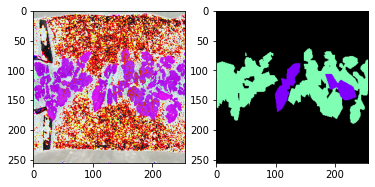

In [32]:
fig, ax = plt.subplots(1, 2)

augmented_img, target = next(iterator)
augmented_img = augmented_img[0]   # First element
augmented_img = augmented_img  # denormalize

target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, num_classes):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

In [33]:
# Encoder
encoder = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

finetuning = True

if finetuning:
    freeze_until = 11 # layer from which we want to fine-tune
    
    for layer in encoder.layers[:freeze_until]:
        layer.trainable = False
else:
    encoder.trainable = False
    for layer in encoder.layers:
        encoder.trainable = False

encoder.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [34]:
def create_model(depth, start_f, num_classes):

    model = tf.keras.Sequential()
    
    # Encoder
    model.add(encoder)
    
    start_f = 256
        
    # Decoder
    for i in range(depth):
        model.add(tf.keras.layers.UpSampling2D(2, interpolation='bilinear'))
        model.add(tf.keras.layers.Conv2D(filters=start_f,
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same'))
        model.add(tf.keras.layers.ReLU())

        start_f = start_f // 2

    # Prediction Layer
    model.add(tf.keras.layers.Conv2D(filters=num_classes,
                                     kernel_size=(1, 1),
                                     strides=(1, 1),
                                     padding='same',
                                     activation='softmax'))
    
    return model
    

model = create_model(depth=5, start_f=8, num_classes=num_classes)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
up_sampling2d_10 (UpSampling (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 256)       1179904   
_________________________________________________________________
re_lu_10 (ReLU)              (None, 16, 16, 256)       0         
_________________________________________________________________
up_sampling2d_11 (UpSampling (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 128)       295040    
_________________________________________________________________
re_lu_11 (ReLU)              (None, 32, 32, 128)      

In [35]:
# Optimization params

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
# learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1, num_classes): # exclude the background class 0
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics
metrics = ['accuracy', meanIoU]
# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [36]:
# Callbacks
callbacks = []

# Early Stopping
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_meanIoU', patience=6, restore_best_weights=True)
    callbacks.append(es_callback)

In [37]:
# Fit the model
model.fit(x=train_dataset,
          epochs=20,  #### set repeat in training dataset
          steps_per_epoch=len(dataset),
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid),
          callbacks=callbacks)

Epoch 1/20
81/81 [==============================] - 289s 4s/step - loss: 0.2116 - accuracy: 0.9163 - meanIoU: 0.1235 - val_loss: 0.2847 - val_accuracy: 0.8892 - val_meanIoU: 0.2727
Epoch 2/20
81/81 [==============================] - 287s 4s/step - loss: 0.1614 - accuracy: 0.9291 - meanIoU: 0.3074 - val_loss: 0.3142 - val_accuracy: 0.8860 - val_meanIoU: 0.2574
Epoch 3/20
81/81 [==============================] - 282s 3s/step - loss: 0.1560 - accuracy: 0.9314 - meanIoU: 0.3198 - val_loss: 0.3658 - val_accuracy: 0.8778 - val_meanIoU: 0.2483
Epoch 4/20
81/81 [==============================] - 289s 4s/step - loss: 0.1415 - accuracy: 0.9373 - meanIoU: 0.3743 - val_loss: 0.2717 - val_accuracy: 0.8953 - val_meanIoU: 0.3191
Epoch 5/20
81/81 [==============================] - 284s 4s/step - loss: 0.1279 - accuracy: 0.9424 - meanIoU: 0.4239 - val_loss: 0.2796 - val_accuracy: 0.8935 - val_meanIoU: 0.2640
Epoch 6/20
81/81 [==============================] - 284s 4s/step - loss: 0.1340 - accuracy: 0.9

In [ ]:
model.save('model_baseline_bipbip_haricot50')

In [ ]:
model = tf.keras.models.load_model('model_baseline_bipbip_haricot50', {'meanIoU': meanIoU})

In [38]:
# Show original, correct, predicted (validation)

iterator = iter(valid_dataset)

<class 'tensorflow.python.framework.ops.EagerTensor'>


(1, 256, 256, 3)

TensorShape([256, 256])

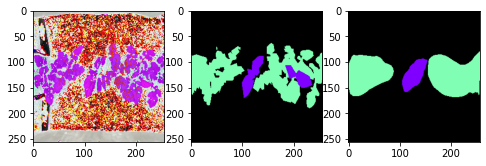

In [47]:
# Show original, correct, predicted (validation)

fig, ax = plt.subplots(1, 3, figsize=(8, 8))
fig.show()
image, target = next(iterator)
print(type(image))
image = image[0]
target = target[0, ..., 0]

out_sigmoid = model.predict(x=tf.expand_dims(image, 0))

predicted_class = tf.argmax(out_sigmoid, -1)

out_sigmoid.shape

predicted_class = predicted_class[0, ...] #256*256
predicted_class.shape

# Assign colors (just for visualization)
target_img = np.zeros([target.shape[0], target.shape[1], 3])
prediction_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, num_classes):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
for i in range(1, num_classes):
  prediction_img[np.where(predicted_class == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(image))
ax[1].imshow(np.uint8(target_img))
ax[2].imshow(np.uint8(prediction_img))

fig.canvas.draw()

In [40]:
# Compute predictions

from os import listdir
from os.path import isfile, join, basename, splitext

# CustomTestDataset to load test images
# Specify the full path to the folder containing the images
class CustomTestDataset(tf.keras.utils.Sequence):

    def __init__(self, dataset_dir, img_generator=None, 
              preprocessing_function=None, out_shape=[img_h, img_w]):

      subset_filenames = [splitext(basename(f))[0] for f in 
                                                listdir(dataset_dir) if isfile(join(dataset_dir, f))]

      self.dataset_dir = dataset_dir
      self.subset_filenames = subset_filenames
      self.img_generator = img_generator
      self.preprocessing_function = preprocessing_function
      self.out_shape = out_shape


    def __len__(self):
        return len(self.subset_filenames)


    def get_original_size(self, index):
        curr_filename = self.subset_filenames[index]
        img = Image.open(os.path.join(self.dataset_dir, curr_filename + '.jpg'))
        width, height = img.size

        return [height, width]


    def __getitem__(self, index):
        # Read Image
        curr_filename = self.subset_filenames[index]
        img = Image.open(os.path.join(self.dataset_dir, curr_filename + '.jpg'))

        # Resize image and mask
        img = img.resize(self.out_shape)
        img_arr = np.array(img)

        if self.preprocessing_function is not None:
            img_arr = self.preprocessing_function(img_arr)

        return img_arr


    def get_name(self, index):
        return self.subset_filenames[index]

In [41]:
def rle_encode(img):
    '''
    img: numpy array, 1 - foreground, 0 - background
    Returns run length as string formatted
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [42]:
import json

test_dir = '/content/Development_Dataset/Test_Dev/Bipbip/Haricot/Images'


test_dataset = CustomTestDataset(test_dir, preprocessing_function=preprocess_input)

submission_dict = {}

for i in range(test_dataset.__len__()):
    image = test_dataset.__getitem__(i)
    img_name = test_dataset.get_name(i)
    original_h, original_w = test_dataset.get_original_size(i)

    prediction = model.predict(tf.expand_dims(image, axis=0))
    mask_arr = tf.argmax(prediction, -1)[0, ...] # (256, 256)
    mask_arr = tf.expand_dims(mask_arr, axis=2)
    print(mask_arr.shape)
    mask_arr = tf.image.resize(mask_arr, (original_h, original_w),                          
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    mask_arr = np.array(mask_arr)

    submission_dict[img_name] = {}
    submission_dict[img_name]['shape'] = [original_h, original_w]
    submission_dict[img_name]['team'] = 'Bipbip'
    submission_dict[img_name]['crop'] = 'Haricot'
    submission_dict[img_name]['segmentation'] = {}

    rle_encoded_crop = rle_encode(mask_arr == 1)
    rle_encoded_weed = rle_encode(mask_arr == 2)

    submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
    submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed

(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)


In [43]:
# empty submission for other datasets
def empty_submission(team, crop, dir):
    images_dir = join(dir, team, crop, 'Images')
    images_name = [splitext(basename(f))[0] for f in listdir(images_dir) if isfile(join(images_dir, f))]
    
    res = {}
    for img_name in images_name:
        res[img_name] = {}
        res[img_name]['shape'] = [256, 256] # non importa molto la shape per le submission vuote
        res[img_name]['team'] = team
        res[img_name]['crop'] = crop
        res[img_name]['segmentation'] = {}
        res[img_name]['segmentation']['crop'] = ""
        res[img_name]['segmentation']['weed'] = ""

    return res

dir = r'/content/Development_Dataset/Test_Dev'
submission_dict.update(empty_submission('Bipbip', 'Mais', dir))
submission_dict.update(empty_submission('Pead', 'Haricot', dir))
submission_dict.update(empty_submission('Pead', 'Mais', dir))
submission_dict.update(empty_submission('Roseau', 'Haricot', dir))
submission_dict.update(empty_submission('Roseau', 'Mais', dir))
submission_dict.update(empty_submission('Weedelec', 'Haricot', dir))
submission_dict.update(empty_submission('Weedelec', 'Mais', dir))

with open('./submission.json', 'w') as f:
    json.dump(submission_dict, f)

In [44]:
# Show original, predicted (test)

test_dataset = CustomTestDataset(test_dir, preprocessing_function=preprocess_input)
test_iter = iter(test_dataset)

[0 1]


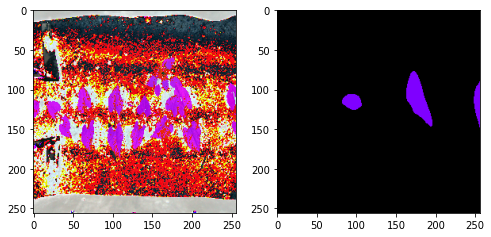

In [48]:
# Show original, predicted (test)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(8, 8))
fig.show()

image = next(test_iter)

out_sigmoid = model.predict(x=tf.expand_dims(image, 0))

predicted_class = tf.argmax(out_sigmoid, -1)[0, ...]
print(np.unique(np.array(predicted_class)))

# Assign colors (just for visualization)
prediction_img = np.zeros([image.shape[0], image.shape[1], 3])

prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
for i in range(1, num_classes+1):
  prediction_img[np.where(predicted_class == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(image))
ax[1].imshow(np.uint8(prediction_img))

fig.canvas.draw()